In [13]:
## Import dependencies
import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 500

# Identification part of the filenames
model_base_name = '250000spec_86Metabolites_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train CNN on dataset of 86 metabolites

In [2]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"CNN_44met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [3]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [14]:
# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset86_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset86_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 86)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 16  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
## Define NN model object, define some parameters, and instantiate model

## Best parameters determined in Optuna study
#{'num_conv_layers': 3, 
# 'kernel_size': 10, 
# 'num_channels': 35, 
# 'pooling_type': 'none', 
# 'conv_stride': 4, 
# 'feedforward_size': 233, 
# 'learning_rate': 2.067749078763321e-05, 
# 'reg_strength': 0.004990448395463014, 
# 'bs': 16}


# Define some model & training parameters
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super(NMR_Model_Aq, self).__init__()
        self.conv1 = nn.Conv1d(1, 35, kernel_size=10, stride=4, padding=1)
        self.conv2 = nn.Conv1d(35, 35, kernel_size=10, stride=4, padding=1)
        self.conv3 = nn.Conv1d(35, 35, kernel_size=10, stride=4, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(25095, 233)
        self.fc2 = nn.Linear(233, 86)

    def forward(self, x):
        x = x.permute(0, 2, 1)                  
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

    
    

In [16]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

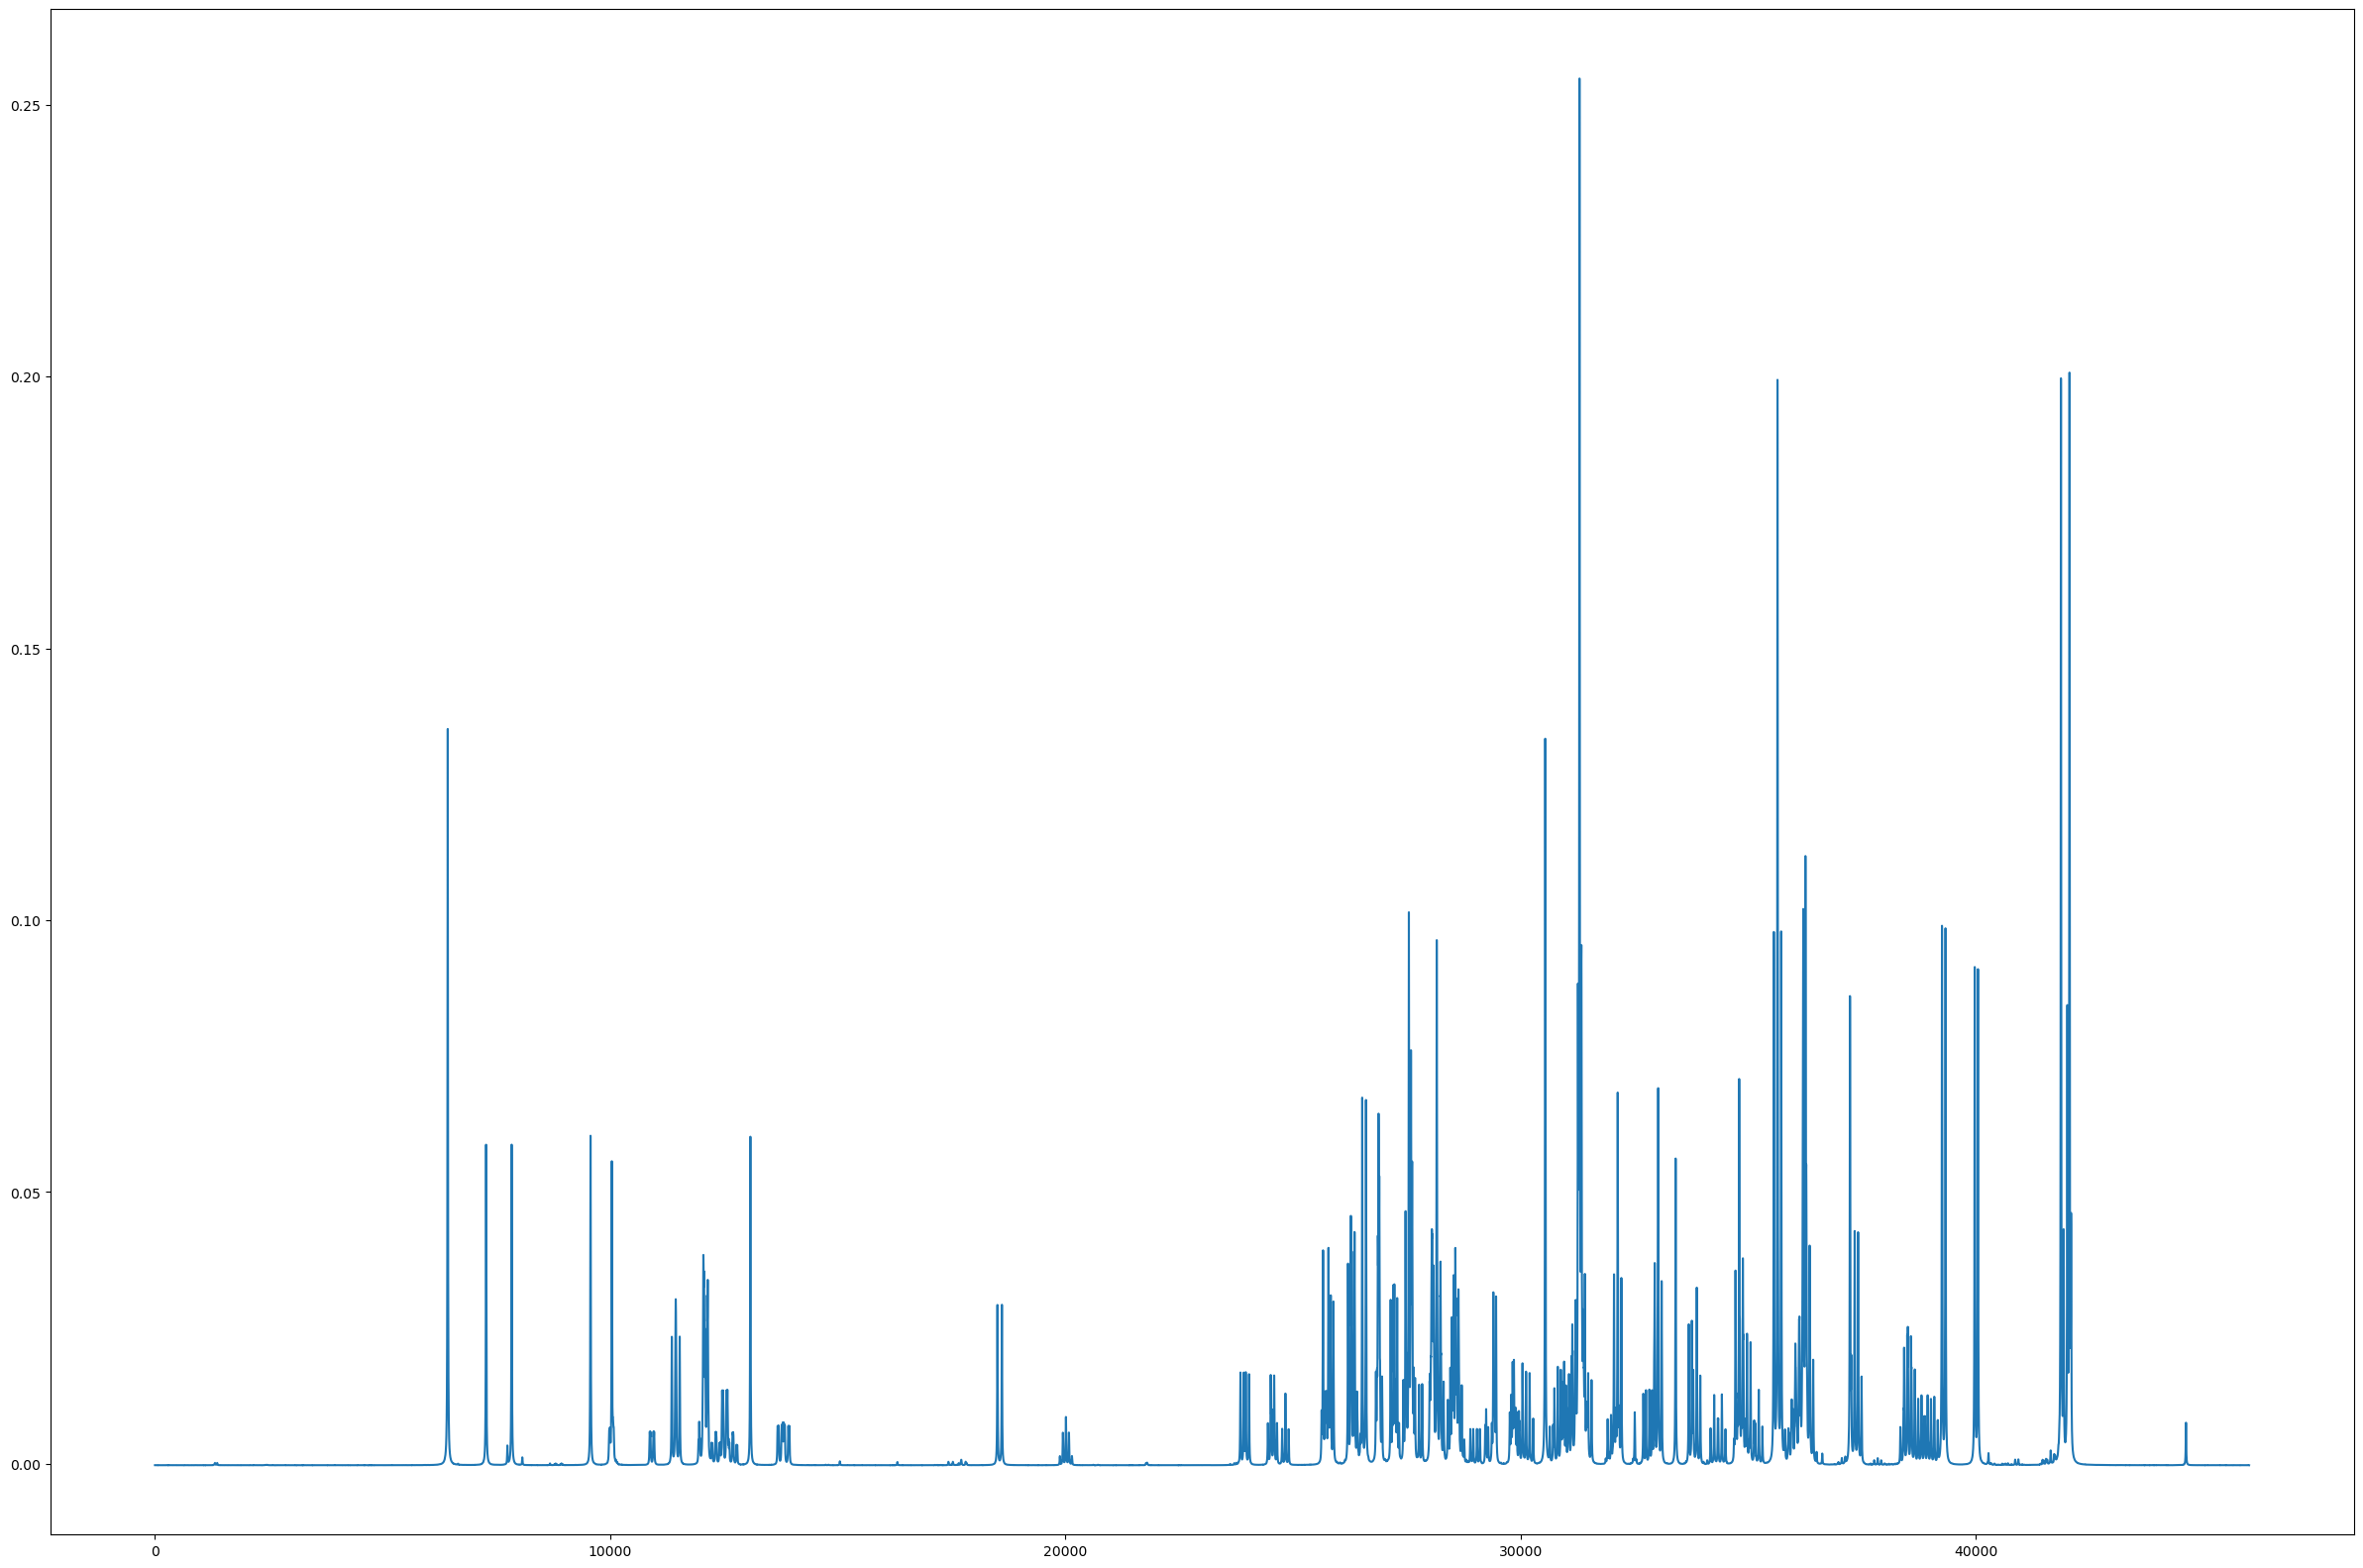

In [17]:
plt.plot(spectra_memmap[200000])

In [18]:
from torch.cuda.amp import GradScaler, autocast


def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr = 2.067749078763321e-05, weight_decay=0.004990448395463014)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs.unsqueeze(2))
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs.unsqueeze(2))
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.AdamW(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [19]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 28110.8129, Test Loss: 26562.4615
Epoch time:  1096.1041011810303
Epoch [2/500], Train Loss: 26505.8116, Test Loss: 26429.5203
Epoch time:  395.62988924980164
Epoch [3/500], Train Loss: 26355.4496, Test Loss: 26242.7838
Epoch time:  396.8497054576874
Epoch [4/500], Train Loss: 26086.5115, Test Loss: 25853.2534
Epoch time:  390.83353543281555
Epoch [5/500], Train Loss: 25520.2122, Test Loss: 25083.8475
Epoch time:  409.4777557849884
Epoch [6/500], Train Loss: 24384.7750, Test Loss: 23511.2383
Epoch time:  437.62317848205566
Epoch [7/500], Train Loss: 22018.1295, Test Loss: 20233.0568
Epoch time:  391.39460921287537
Epoch [8/500], Train Loss: 18072.1820, Test Loss: 16398.6307
Epoch time:  377.1026747226715
Epoch [9/500], Train Loss: 15504.1731, Test Loss: 14748.6652
Epoch time:  379.43570613861084
Epoch [10/500], Train Loss: 14202.9693, Test Loss: 13778.3898
Epoch time:  363.9855296611786
Epoch [11/500], Train L

Epoch [90/500], Train Loss: 7208.2243, Test Loss: 7223.5046
Epoch time:  469.5187659263611
Epoch [91/500], Train Loss: 7202.2312, Test Loss: 7220.8016
Epoch time:  419.44780588150024
Epoch [92/500], Train Loss: 7193.4874, Test Loss: 7227.4185
Epoch time:  376.0324664115906
Epoch [93/500], Train Loss: 7193.0113, Test Loss: 7217.5142
Epoch time:  404.21757078170776
Epoch [94/500], Train Loss: 7197.8914, Test Loss: 7227.8246
Epoch time:  373.4917063713074
Epoch [95/500], Train Loss: 7186.1979, Test Loss: 7217.6111
Epoch time:  368.0751624107361
Epoch [96/500], Train Loss: 7189.1184, Test Loss: 7216.8206
Epoch time:  368.1140594482422
Epoch [97/500], Train Loss: 7182.0611, Test Loss: 7216.0983
Epoch time:  349.692049741745
Epoch [98/500], Train Loss: 7168.8286, Test Loss: 7205.0484
Epoch time:  404.40974259376526
Epoch [99/500], Train Loss: 7170.9523, Test Loss: 7214.6545
Epoch time:  401.14990401268005
Epoch [100/500], Train Loss: 7164.3556, Test Loss: 7183.7736
Epoch time:  387.235723733

Epoch [179/500], Train Loss: 6885.0802, Test Loss: 6911.1619
Epoch time:  437.7816233634949
Epoch [180/500], Train Loss: 6884.1281, Test Loss: 6956.8451
Epoch time:  435.1827275753021
Epoch [181/500], Train Loss: 6880.5909, Test Loss: 6920.0372
Epoch time:  505.15722131729126
Epoch [182/500], Train Loss: 6884.0919, Test Loss: 6899.0936
Epoch time:  436.43354964256287
Epoch [183/500], Train Loss: 6876.9223, Test Loss: 6890.1551
Epoch time:  523.1878523826599
Epoch [184/500], Train Loss: 6884.6102, Test Loss: 6894.6276
Epoch time:  475.6842164993286
Epoch [185/500], Train Loss: 6876.4388, Test Loss: 6914.3179
Epoch time:  492.4464023113251
Epoch [186/500], Train Loss: 6882.0501, Test Loss: 6891.2698
Epoch time:  400.2087936401367
Epoch [187/500], Train Loss: 6873.4075, Test Loss: 6902.5542
Epoch time:  465.0719633102417
Epoch [188/500], Train Loss: 6879.0305, Test Loss: 6910.7120
Epoch time:  500.1198709011078
Epoch [189/500], Train Loss: 6882.3728, Test Loss: 6891.5837
Epoch time:  519.

Epoch [268/500], Train Loss: 6826.8122, Test Loss: 6889.2056
Epoch time:  370.1088845729828
Epoch [269/500], Train Loss: 6826.1020, Test Loss: 6830.2370
Epoch time:  394.1489577293396
Epoch [270/500], Train Loss: 6833.4888, Test Loss: 6848.1462
Epoch time:  372.20021629333496
Epoch [271/500], Train Loss: 6820.6759, Test Loss: 6844.7478
Epoch time:  358.1239321231842
Epoch [272/500], Train Loss: 6821.9267, Test Loss: 6862.7850
Epoch time:  383.6174626350403
Epoch [273/500], Train Loss: 6821.3222, Test Loss: 6845.1202
Epoch time:  400.8217315673828
Epoch [274/500], Train Loss: 6826.4554, Test Loss: 6842.8288
Epoch time:  345.241064786911
Epoch [275/500], Train Loss: 6825.6753, Test Loss: 6866.0891
Epoch time:  372.22713923454285
Epoch [276/500], Train Loss: 6820.3187, Test Loss: 6843.7168
Epoch time:  406.4949424266815
Epoch [277/500], Train Loss: 6815.6940, Test Loss: 6860.9232
Epoch time:  336.081889629364
Epoch [278/500], Train Loss: 6815.9773, Test Loss: 6849.4069
Epoch time:  362.43

Epoch [357/500], Train Loss: 6789.5984, Test Loss: 6799.5446
Epoch time:  315.0547528266907
Epoch [358/500], Train Loss: 6787.2986, Test Loss: 6817.3766
Epoch time:  294.99008083343506
Epoch [359/500], Train Loss: 6785.1351, Test Loss: 6845.9302
Epoch time:  283.7549571990967
Epoch [360/500], Train Loss: 6792.4414, Test Loss: 6860.5827
Epoch time:  292.88503432273865
Epoch [361/500], Train Loss: 6794.6061, Test Loss: 6797.5082
Epoch time:  900.8070073127747
Epoch [362/500], Train Loss: 6785.1619, Test Loss: 6816.4206
Epoch time:  580.7527153491974
Epoch [363/500], Train Loss: 6792.3932, Test Loss: 6801.8197
Epoch time:  230.3871431350708
Epoch [364/500], Train Loss: 6787.5355, Test Loss: 6829.0851
Epoch time:  240.65827083587646
Epoch [365/500], Train Loss: 6793.7729, Test Loss: 6809.4483
Epoch time:  224.63407588005066
Epoch [366/500], Train Loss: 6781.1830, Test Loss: 6817.4490
Epoch time:  216.72853183746338
Epoch [367/500], Train Loss: 6786.1750, Test Loss: 6827.8695
Epoch time:  2

Epoch [446/500], Train Loss: 6758.4226, Test Loss: 6781.1241
Epoch time:  269.7083864212036
Epoch [447/500], Train Loss: 6763.9780, Test Loss: 6799.4888
Epoch time:  269.1040048599243
Epoch [448/500], Train Loss: 6760.2864, Test Loss: 6794.9476
Epoch time:  291.0004994869232
Epoch [449/500], Train Loss: 6758.0141, Test Loss: 6780.4292
Epoch time:  260.923632144928
Epoch [450/500], Train Loss: 6757.1592, Test Loss: 6776.8073
Epoch time:  293.6631371974945
Epoch [451/500], Train Loss: 6759.7768, Test Loss: 6793.7468
Epoch time:  292.16023111343384
Epoch [452/500], Train Loss: 6755.2338, Test Loss: 6783.0234
Epoch time:  291.0639822483063
Epoch [453/500], Train Loss: 6757.6854, Test Loss: 6767.9882
Epoch time:  293.210569858551
Epoch [454/500], Train Loss: 6757.0340, Test Loss: 6785.5528
Epoch time:  319.3682324886322
Epoch [455/500], Train Loss: 6760.0090, Test Loss: 6806.7824
Epoch time:  296.6382269859314
Epoch [456/500], Train Loss: 6753.2243, Test Loss: 6778.4195
Epoch time:  273.765

In [20]:
np.array(test_losses).min()

6754.935935139656

In [21]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset86_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset86_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_86met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_86met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_86met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_86met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_86met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_86met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_86met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_86met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_86met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_86met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_86met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_86met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_86met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_86met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_86met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_86met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_86met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_86met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_86met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_86met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [22]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

NMR_Model_Aq(
  (conv1): Conv1d(1, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (conv2): Conv1d(35, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (conv3): Conv1d(35, 35, kernel_size=(10,), stride=(4,), padding=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25095, out_features=233, bias=True)
  (fc2): Linear(in_features=233, out_features=86, bias=True)
)

In [23]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0).unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  166.6566502024138


In [24]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
100.82  - Concentrations: 0.004999999888241291
20.33  - Concentrations: 0.02500000037252903
9.81  - Concentrations: 0.10000000149011612
13.12  - Concentrations: 0.25
10.22  - Concentrations: 0.5
11.9  - Concentrations: 1.0
17.9  - Concentrations: 2.5
7.13  - Concentrations: 10.0
1.07  - Concentrations: 20.0


In [25]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  40.69923
--------------------
18.99  - Min Value: 0.2735  - Mean Value: 10.0
39.18  - Min Value: 0.2585  - Mean Value: 10.3
20.78  - Min Value: 1.1016  - Mean Value: 9.9
100.87  - Min Value: 0.1107  - Mean Value: 10.2
81.85  - Min Value: 0.099  - Mean Value: 9.7
32.0  - Min Value: 0.5492  - Mean Value: 10.5
18.87  - Min Value: 0.2504  - Mean Value: 9.4
47.37  - Min Value: 0.2381  - Mean Value: 11.0
26.92  - Min Value: 0.3283  - Mean Value: 9.9
20.17  - Min Value: 0.6191  - Mean Value: 9.6


In [26]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  25.873203
--------------------
19.26  - Min Value: 0.0054  - Mean Value: 0.1
15.75  - Min Value: 0.0173  - Mean Value: 0.1
40.73  - Min Value: 0.0068  - Mean Value: 0.1
26.79  - Min Value: 0.0089  - Mean Value: 0.1
27.18  - Min Value: 0.0062  - Mean Value: 0.1
18.02  - Min Value: 0.0059  - Mean Value: 0.1
23.55  - Min Value: 0.008  - Mean Value: 0.1
37.34  - Min Value: 0.0051  - Mean Value: 0.1
28.7  - Min Value: 0.005  - Mean Value: 0.1
21.42  - Min Value: 0.0063  - Mean Value: 0.1


In [27]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  55.846367
--------------------
48.2  - Min Value: 0.0062  - Mean Value: 1.3
74.69  - Min Value: 0.0066  - Mean Value: 0.7
50.22  - Min Value: 0.0127  - Mean Value: 0.6
90.63  - Min Value: 0.0092  - Mean Value: 0.8
55.11  - Min Value: 0.0055  - Mean Value: 0.6
50.4  - Min Value: 0.0097  - Mean Value: 0.8
33.8  - Min Value: 0.0063  - Mean Value: 0.9
66.22  - Min Value: 0.0066  - Mean Value: 0.7
47.75  - Min Value: 0.0055  - Mean Value: 0.7
41.45  - Min Value: 0.0163  - Mean Value: 0.9


In [28]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

IndexError: index 44 is out of bounds for dimension 0 with size 44

In [29]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  760.1205
--------------------
475.31  - Min Value: 0.0057  - Mean Value: 6.9
1898.35  - Min Value: 0.0085  - Mean Value: 7.1
690.74  - Min Value: 0.006  - Mean Value: 7.1
1958.66  - Min Value: 0.0067  - Mean Value: 8.8
316.26  - Min Value: 0.007  - Mean Value: 7.7
228.82  - Min Value: 0.0083  - Mean Value: 7.8
634.99  - Min Value: 0.0067  - Mean Value: 6.9
632.46  - Min Value: 0.0064  - Mean Value: 7.3
315.64  - Min Value: 0.0061  - Mean Value: 8.2
449.98  - Min Value: 0.0073  - Mean Value: 6.7


In [30]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x29190 and 25095x233)

In [ ]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

In [ ]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i].unsqueeze(2))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(86):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

In [31]:
Pred = model_aq(OtherValSpectra[0].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 1s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3].unsqueeze(2))
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.4796, 0.5931, 0.3685, 0.5040, 0.6083, 0.5326, 0.5957, 0.6775, 0.8374,
        0.4328, 0.5775, 0.2970, 0.6318, 0.2753, 0.2745, 0.2896, 0.6411, 0.4860,
        0.5813, 0.3966, 0.3937, 1.2027, 0.2210, 0.6575, 0.2615, 0.5323, 0.6067,
        0.8866, 0.8026, 0.4929, 0.4876, 1.1098, 0.5441, 0.4344, 0.4535, 0.5522,
        0.2945, 0.2758, 0.2743, 0.5446, 0.4277, 0.5446, 0.6950, 0.5639, 0.7317,
        0.3257, 0.3065, 0.2897, 0.6791, 0.7356, 0.5653, 0.3878, 0.5263, 0.2542,
        0.2474, 0.2759, 0.4210, 0.2655, 0.4510, 0.1890, 0.9518, 0.4739, 0.7226,
        0.4043, 0.2732, 0.3971, 0.4344, 0.6322, 0.3170, 0.2383, 0.3413, 0.5748,
        0.2846, 0.2738, 0.2923, 0.3860, 0.4035, 0.2115, 0.5014, 0.5108, 0.6006,
        0.3891, 0.2713, 0.6002, 0.4480, 0.5968], device='cuda:0',
       grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.3790, 0.7737, 0.0000, 0.5064, 0.4130, 0.4473, 0.4226, 0.1043, 0.5955,
        0.6625, 0.3486, 0.2799, 